## 1. Package Import

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud


## 2. Data Import

In [2]:
df = pd.read_csv('spotify_reviews.csv')
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


## 3. Data Pre-processing

In [3]:
print(f'Original Spotify review data sets contains {len(df)} rows')
print(f'There are {len(df.columns)} columns: ')
for col in df.columns:
    print(f'• {col}')


Original Spotify review data sets contains 84165 rows
There are 8 columns: 
• reviewId
• userName
• content
• score
• thumbsUpCount
• reviewCreatedVersion
• at
• appVersion


In [4]:
print(f'Missing values in each column: ')
print(f'{df.isnull().sum()}')

Missing values in each column: 
reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64


##### 3.1 Data Cleaning Strategy
* The goal of this project is to analyze the sentiment of user's feedback of different version. Therefore, the data cleaning strategy is to drop all the rows that contains NA values, inserting a mean value or some value x (such as 'Unknow Version' or 0.0.0) will not suit the goal of this project.

In [5]:
df_clean = df.dropna()
print("Each column's missing value after cleaned: ")
print(f'{df_clean.isnull().sum()}')

Each column's missing value after cleaned: 
reviewId                0
userName                0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
appVersion              0
dtype: int64


In [6]:
df_clean.loc[:,'at']

1        2024-05-09 16:27:18
2        2024-05-09 16:27:03
3        2024-05-09 16:26:19
4        2024-05-09 16:26:14
5        2024-05-09 16:24:51
                ...         
84159    2019-04-26 02:58:15
84160    2020-04-30 10:02:07
84161    2019-10-11 16:28:13
84163    2020-03-28 03:50:24
84164    2020-06-13 03:27:52
Name: at, Length: 78393, dtype: object

In [7]:
df_clean['at'] = pd.to_datetime(df_clean['at'])
df_clean['year'] = df_clean['at'].dt.year

/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_2161/1706107376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['at'] = pd.to_datetime(df_clean['at'])
/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_2161/1706107376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['year'] = df_clean['at'].dt.year


##### 3.2 Initial Data Visualization

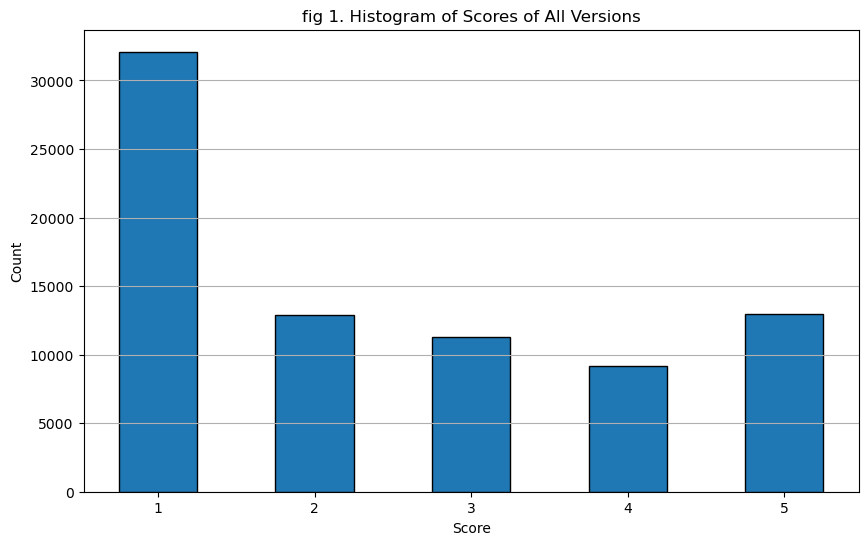

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['score'], 
         bins=[0.5 + i for i in range(6)], 
         edgecolor='black',
        rwidth = 0.5)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('fig 1. Histogram of Scores of All Versions')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()


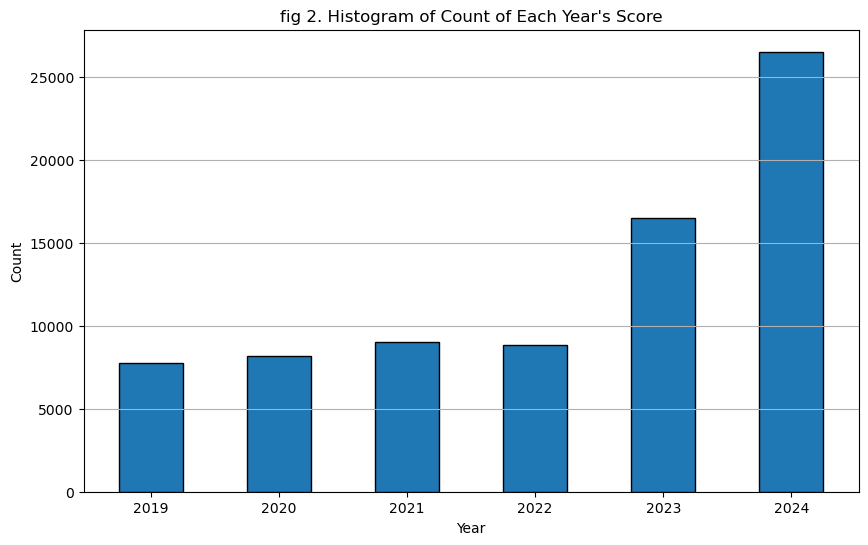

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['year'], 
         bins=[0.5 + i for i in range(2018, 2025)], 
         edgecolor='black',
        rwidth = 0.5)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title("fig 2. Histogram of Count of Each Year's Score")
plt.grid(axis='y')
plt.show()

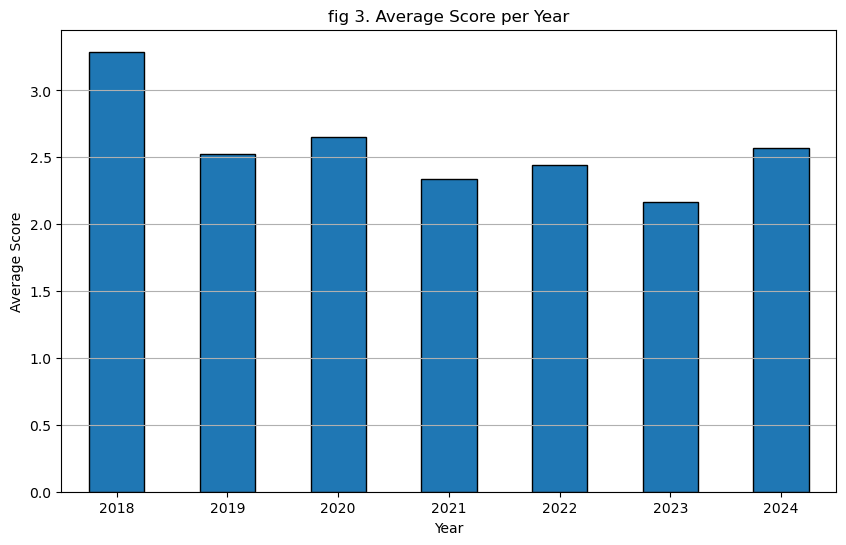

In [29]:
average_scores_per_year = df_clean.groupby('year')['score'].mean()

plt.figure(figsize=(10, 6))
average_scores_per_year.plot(kind='bar', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.title('fig 3. Average Score per Year')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

##### 3.3 Summary

The number of 1 score reviews is the highest for spotify, more reviews are in year 2024, and the general trend of the average score in each year from 2018 to 2024 is decreasing, year 2023 has the lowest average score.

## 4. Text cleaning
* Symbols removing
* Drop non-english characters
* text tokenize
* text lemmatize

In [38]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/penglishao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [75]:
def text_cleaner(t):
    #Remove all text that is either a word, number, or a space, make sure it is english
    t = re.sub(r'[^a-zA-Z0-9\s]', '', t)
    
    #Lower
    t = t.lower()
    
    #Word tokenize and remove stop words
    wt = word_tokenize(t)
    
    sw = set(stopwords.words('english'))
    filtered_text = [w for w in wt if w not in sw]
    
    #Transform words to basic norm form
    lemma_text = [lemmatizer.lemmatize(w) for w in filtered_text]
    #Transform word to basic verb form
    lemma_text = [lemmatizer.lemmatize(w, pos = 'v') for w in lemma_text]
    
    return ' '.join(lemma_text)

In [76]:
df_clean['clean_content'] = df_clean['content'].apply(text_cleaner)
print(df_clean[['content', 'clean_content']].head())


                                             content  \
1  I love this app so much, I've been using Spoti...   
2                                            Perfect   
3  Best all around music streaming app I have use...   
4  Are y'all fr gatekeeping the play button on so...   
5                                           Loved it   

                                       clean_content  
1  love app much ive use spotify 2 year different...  
2                                            perfect  
3  best around music stream app use family plan g...  
4               yall fr gatekeeping play button song  
5                                               love  


/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_2161/2220158706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_content'] = df_clean['content'].apply(text_cleaner)


## 5. Key-word Extraction & Word Cloud

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df_clean['clean_content'])

keywords = vectorizer.get_feature_names_out()
print(keywords)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=keywords)
print(tfidf_df)

['10' '30' 'able' 'account' 'actually' 'ad' 'add' 'album' 'allow' 'almost'
 'already' 'also' 'always' 'amaze' 'android' 'annoy' 'another' 'anymore'
 'anything' 'app' 'apps' 'artist' 'back' 'bad' 'become' 'best' 'better'
 'bug' 'button' 'buy' 'cancel' 'cant' 'car' 'change' 'choose' 'click'
 'close' 'come' 'completely' 'connect' 'connection' 'constantly' 'could'
 'crash' 'data' 'day' 'delete' 'device' 'didnt' 'different' 'disappoint'
 'doesnt' 'dont' 'download' 'easy' 'enjoy' 'even' 'ever' 'every'
 'everything' 'experience' 'favorite' 'feature' 'find' 'fine' 'first'
 'fix' 'force' 'free' 'frustrate' 'get' 'give' 'go' 'good' 'great'
 'happen' 'hate' 'hear' 'help' 'hour' 'however' 'ill' 'im' 'instead'
 'internet' 'isnt' 'issue' 'ive' 'keep' 'know' 'last' 'let' 'library'
 'like' 'limit' 'list' 'listen' 'load' 'log' 'long' 'look' 'lot' 'love'
 'lyric' 'make' 'many' 'minute' 'mobile' 'mode' 'money' 'month' 'much'
 'music' 'need' 'never' 'new' 'next' 'nothing' 'offline' 'one' 'open'
 'option' 

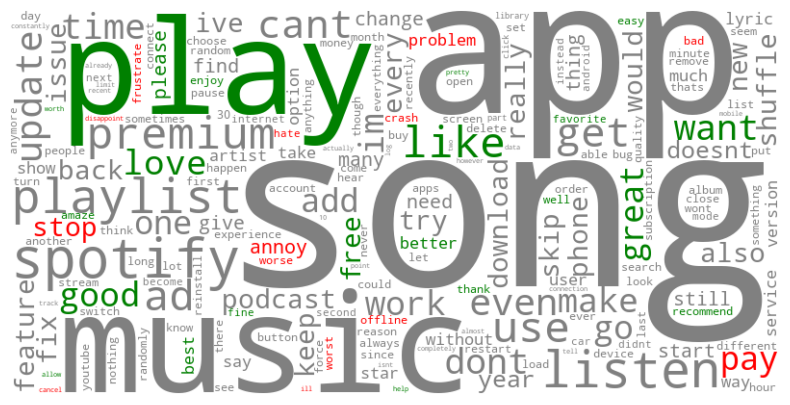

In [97]:
word_freq = {word: tfidf_matrix[:, i].sum() for i, word in enumerate(keywords)}

word_sentiments = {word: sentiment_analyzer(word) for word in keywords}

def color_func(word, *args, **kwargs):
    sentiment = word_sentiments.get(word, 'neutral')
    if sentiment == 'positive':
        return 'green'
    elif sentiment == 'negative':
        return 'red'
    else:
        return 'grey'

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 6. Setiment Analysis

##### 6.1 Sentiment Identification
Identify the sentiment of comments: 
* Positive
* Negative
* Neutral

In [88]:
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer(t):
    scores = analyzer.polarity_scores(t)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
df_clean['sentiment'] = df_clean['clean_content'].apply(sentiment_analyzer)


/var/folders/55/hwcyl2mj2v32sqxxp1k85wr80000gn/T/ipykernel_2161/2679094111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment'] = df_clean['clean_content'].apply(sentiment_analyzer)


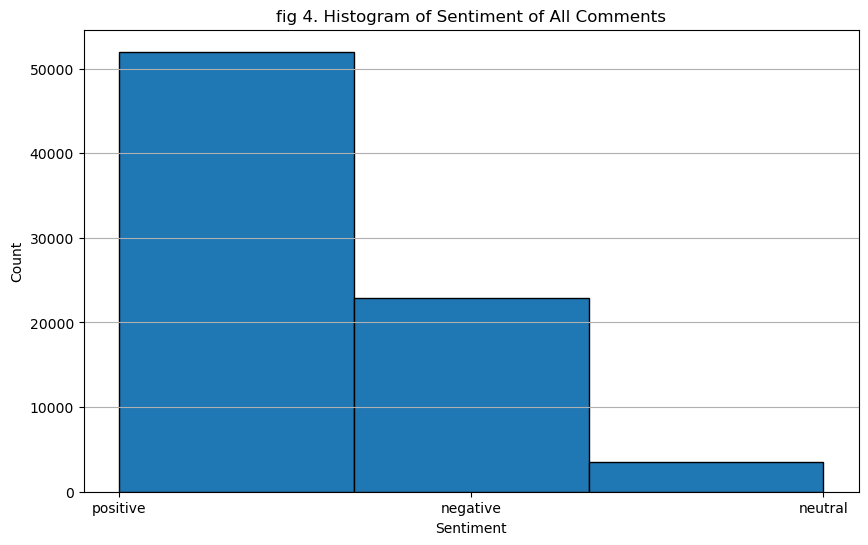

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(df_clean['sentiment'],
         bins = 3,
         edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('fig 4. Histogram of Sentiment of All Comments')
plt.grid(axis='y')
plt.show()